In [1]:
#CS 447 Final Project

In [2]:
#used generally
import math
import pandas as pd
import numpy as np
from pathlib import Path
#used for formatting data
#from sklearn.preprocessing import OneHotEncoder
#used for decision tree
from sklearn import tree
#used for random forest
from sklearn import ensemble
#used for cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#used for ROC curves and accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [3]:
#Clean data

In [4]:
#headers of columns
headers = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation",
                                     "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
#reads in from csv to pds dataframe
#adult data
ad = pd.read_csv("adult.data", names=headers)
ad.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
#adult test data
at = pd.read_csv("adult.test", skiprows=1, names=headers)
at.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
#combine training set with test set for cross validation
total = pd.concat([at, ad])
total.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [7]:
#number of instances before removing missing value instances
print(len(total.index))

48842


In [8]:
#remove instances with missing information
for header in headers:
    total = total[total[header].astype(str).str.contains("\?") == False]
    
#remove trailing . from label row in adult.test
total["income"] = total["income"].str.replace(".", "") 

#number of instances after removing missing value instances
print(len(total.index))

45222


C:\Users\zc6800md\AppData\Local\Temp\ipykernel_1176\1439233830.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total["income"] = total["income"].str.replace(".", "")


In [9]:
#split the label from the features
X = total.drop("income", axis=1)
y = total[["income"]].copy()
y.head()

,income
0,<=50K
1,<=50K
2,>50K
3,>50K
5,<=50K


In [10]:
#function used to encode the label
def clean_Y(inp):
    if inp == " <=50K":
        return 0
    else:
        return 1

In [11]:
#turns <=50k to 0, >50k to 1
y = y.applymap(clean_Y)

y.head(10)

,income
0,0
1,0
2,1
3,1
5,0
7,1
8,0
9,0
10,1
11,0


In [12]:
#one hot encode the categorical columns
X_encoded = pd.get_dummies(X, columns=["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex",
                                      "native_country"])
X_encoded.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
#Create 2 models

In [14]:
#decision tree - model
clf = tree.DecisionTreeClassifier()
clf.fit(X_encoded, y)

DecisionTreeClassifier()

In [15]:
#random forest - model
randForest = ensemble.RandomForestClassifier(criterion="entropy")
randForest.fit(X_encoded, y.values.ravel())

RandomForestClassifier(criterion='entropy')

In [16]:
#Feature selection

In [17]:
#decision trees - feature selection
feature_imp = pd.Series(clf.feature_importances_, index = X_encoded.columns).sort_values(ascending = False)
print(feature_imp)

marital_status_ Married-civ-spouse            0.199147
fnlwgt                                        0.196481
education_num                                 0.113976
age                                           0.109461
capital_gain                                  0.105857
                                                ...   
native_country_ Honduras                      0.000000
native_country_ Scotland                      0.000000
native_country_ Thailand                      0.000000
native_country_ Outlying-US(Guam-USVI-etc)    0.000000
native_country_ Holand-Netherlands            0.000000
Length: 104, dtype: float64


In [18]:
#random forests - feature selection
feature_imp = pd.Series(randForest.feature_importances_, index = X_encoded.columns).sort_values(ascending = False)
print(feature_imp)

fnlwgt                                        0.175896
age                                           0.160815
capital_gain                                  0.090066
hours_per_week                                0.083985
marital_status_ Married-civ-spouse            0.064842
                                                ...   
native_country_ Thailand                      0.000072
native_country_ Outlying-US(Guam-USVI-etc)    0.000043
occupation_ Armed-Forces                      0.000037
native_country_ Honduras                      0.000022
native_country_ Holand-Netherlands            0.000000
Length: 104, dtype: float64


In [19]:
'''
Overfitting:
Since our dataset is very large, more possibilities are covered in the data. A couple features involved, some could take 
importance away from more significant features. With small set of features, training the model is less complex, less
oppurtunity for noise in data. Decision tree models are prone to overfiting unlike random forests. 
'''

'\nOverfitting:\nSince our dataset is very large, more possibilities are covered in the data. A couple features involved, some could take \nimportance away from more significant features. With small set of features, training the model is less complex, less\noppurtunity for noise in data. Decision tree models are prone to overfiting unlike random forests. \n'

In [20]:
#Cross-validate, plot ROC curves, final AUROC measurement

In [21]:
#Cross-validation
#fold on 80% / 20% split
kf = KFold(n_splits=5)

#for ROC curves
y_test_list = pd.DataFrame()
dec_preds_list = []
randF_preds_list = []

#for accuracy
dec_acc_scores = []
randF_acc_scores = []

#for each kfold split, fit the tree and get the acc and auc scores
for train_index, test_index in kf.split(X_encoded):
    #split test and training data
    X_train, X_test = X_encoded.iloc[train_index, :], X_encoded.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]
    
    #train decision trees
    clf.fit(X_train, y_train)
    #test decision trees
    clf_preds = clf.predict(X_test)    
    dec_preds_list.append(clf_preds)
    
    #train random forest 
    randForest.fit(X_train, y_train.values.ravel())
    #test random forest
    randF_preds = randForest.predict(X_test)
    randF_preds_list.append(randF_preds)
    
    #decision tree accuracy
    clf_acc = accuracy_score(clf_preds, y_test)
    dec_acc_scores.append(clf_acc)
    
    #random forest accuracy
    randF_acc = accuracy_score(randF_preds, y_test)
    randF_acc_scores.append(randF_acc)

    #concat all test labels
    y_test_list = pd.concat([y_test_list, y_test])

In [ ]:
'''
Cross-validation:
When using cross-validation, all data in the data set is used for training the model, checking all possible outcomes 
for overfitting. Leave-One-Out is not used due to the extreme expense and computation time. 
'''

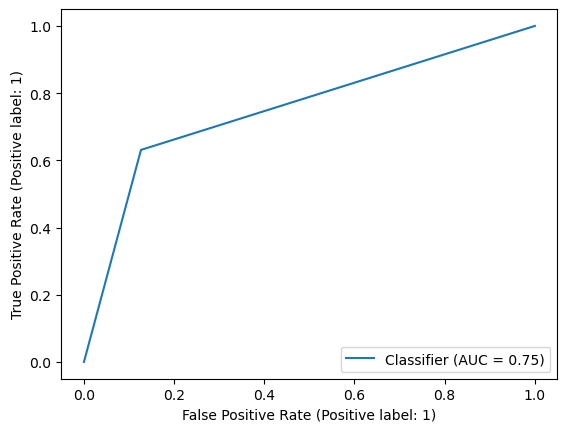

In [22]:
#Plot ROC curve and get AUC score
#decision tree
decTestTotalList = [item for sublist in dec_preds_list for item in sublist]
RocCurveDisplay.from_predictions(y_test_list, decTestTotalList)

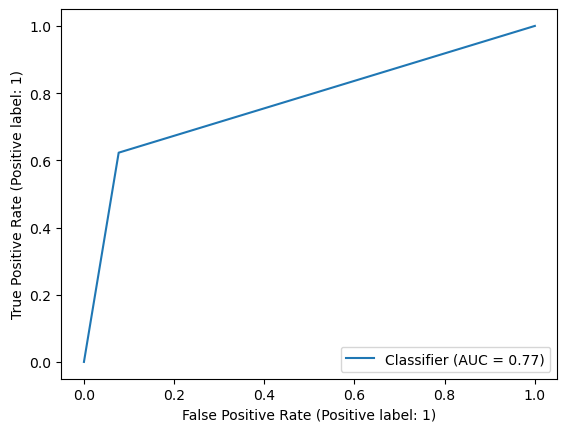

In [23]:
#random forest
randFTestTotalList = [item for sublist in randF_preds_list for item in sublist]
RocCurveDisplay.from_predictions(y_test_list, randFTestTotalList)

In [24]:
#Average Accuracy
#decision tree
dec_avg_acc = sum(dec_acc_scores) / len(dec_acc_scores)
print(dec_avg_acc)

0.813431664714415


In [25]:
#random forest
randF_avg_acc = sum(randF_acc_scores) / len(randF_acc_scores)
print(randF_avg_acc)

0.8485694041952996


In [ ]:
'''
Ethical issues:
Since this dataset predicts income, the government could determine how
federal funding is distributed. If false positives and true negatives
exist, funding could be incorrectly distributed. 
'''